Note: this notebook is based on pymc3's official tutorial.

reference: https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html

In [3]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymc3.math import logsumexp


env: THEANO_FLAGS=device=cpu,floatX=float32


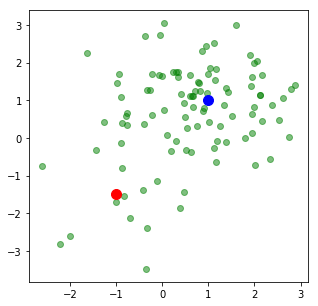

In [197]:
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]]) #mean
ps = np.array([0.2, 0.8]) # pi

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

## Define log_likelihood function, and model

In [198]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

# create a GMM
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    

In [199]:
model.deterministics

[pi]

In [200]:
type(model.basic_RVs[2])

pymc3.model.FreeRV

For comparison of ADVI, run MCMC

In [201]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

logp = -384.33, ||grad|| = 62.173: 100%|██████████| 4/4 [00:00<00:00, 614.26it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1804.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


(-6, 6)

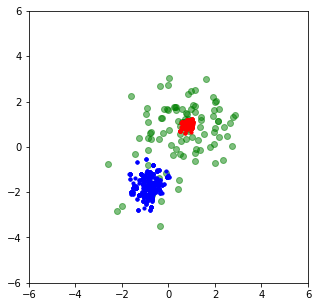

In [202]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

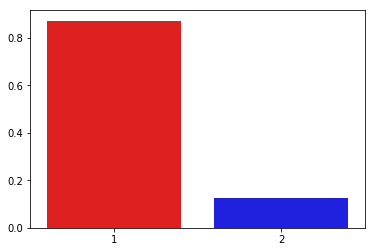

In [203]:
sns.barplot([1, 2], np.mean(trace['pi'][-5000:], axis=0),
            palette=['red', 'blue'])

Use ADVI

In [204]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 323.92: 100%|██████████| 4500/4500 [00:04<00:00, 925.66it/s] 
Finished [100%]: Average Loss = 323.92


CPU times: user 6.72 s, sys: 1.12 s, total: 7.84 s
Wall time: 7.57 s


In [207]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

(-6, 6)

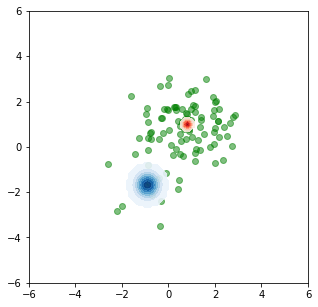

In [208]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

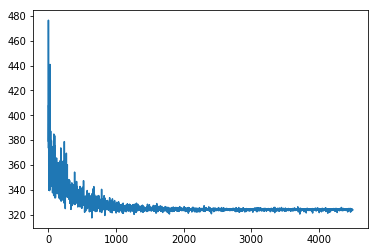

In [210]:
plt.plot(approx.hist)

In [216]:
approx

In [219]:
means

{'pi_stickbreaking__': array([1.9297637], dtype=float32),
 'mu_1': array([-0.90052634, -1.6774162 ], dtype=float32),
 'mu_0': array([0.8154777, 0.9910714], dtype=float32)}

In [223]:
sds

{'pi_stickbreaking__': array([0.3452687], dtype=float32),
 'mu_1': array([0.3088255 , 0.33648196], dtype=float32),
 'mu_0': array([0.10888502, 0.11449332], dtype=float32)}